## Local Import

* working localy trim the data to ensure you can work with it locally <br\>*(my computer does not have sufficient local memory to join all tables so I use appropriate attributes)*

attempted stratagy (merge pd_df until memory bound then print to file)

In [1]:
import json, csv, os
import pandas as pd


def JSON_to_dataFrame(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() ] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df


In [2]:
root_path = "/Users/2015mbp16gb256gb/Documents/school/Fall_2019/4502-Data_Mining/Group_Project/Group1/yelp_dataset/"
rbu_path = root_path + "rbu_merge.json"
filtered_merge_path = root_path + "filtered_merge.json"

## Reviewing Business File

In [3]:
# If import's not install pip install all

# import sys
# try: 
#    !{sys.executable} -m pip install plotly --upgrade
#    !{sys.executable} -m pip install geopandas==0.3.0
#    !{sys.executable} -m pip install pyshp==1.2.10
#    !{sys.executable} -m pip install shapely==1.6.3
#    !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"
#    !{sys.executable} -m pip install chart_studio
#    !{sys.executable} -m pip install plotly-geo
#    !{sys.executable} -m pip install folium
# except ImportError: 
#    print("already installed")

In [4]:
# imports

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

# clustering imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# plotly imports 
import plotly
from plotly import __version__
print('running plotly = {}'.format(__version__))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objects as go

from sklearn.decomposition import PCA 

running plotly = 4.2.1


In [5]:
# for plotly ofline 
init_notebook_mode(connected=True)

In [6]:
%%time

# add text to plot 

business_df = JSON_to_dataFrame(root_path + "business.json")
business_df['text'] = business_df['state'] + ', ' + business_df['city']

CPU times: user 3.97 s, sys: 376 ms, total: 4.34 s
Wall time: 4.36 s


### Reviewing The Buiness Data

In [7]:
# display states/province in business file
business_df.groupby('state').state.count()

state
AB      8012
AK         2
AL         3
AR         1
AZ     56686
BAS        1
BC         1
CA        19
CON        1
CT         3
DOW        1
DUR        1
FL         4
GA         2
IL      1932
NC     14720
NE         2
NJ         1
NM         1
NV     36312
NY        22
OH     14697
ON     33412
PA     11216
QC      9219
SC      1162
TN         1
TX         6
UT         1
VA         2
VT         2
WA         3
WI      5154
XGL        1
XGM        4
XWY        2
Name: state, dtype: int64

* 11 main states found

### Kmeans Attempt

* Kmeans can be sensative to outliers but most of the information is naturally clumped so we dont have to worry 

In [8]:
def find_df_groups_plus_kmeans(df, lat, lon, n_clusters): 
    # transform the data 
    coordinates_df = df[[lat, lon]].copy()

    pca = PCA(n_components=2)
    coordinates = pca.fit_transform(coordinates_df)
    
    #Train model
    kmeans = KMeans(n_clusters=n_clusters).fit(coordinates)
    
    # assign lables
    df['labels'] = pd.DataFrame(kmeans.labels_)
    
    return (df, kmeans)

*use elbow method to find k*

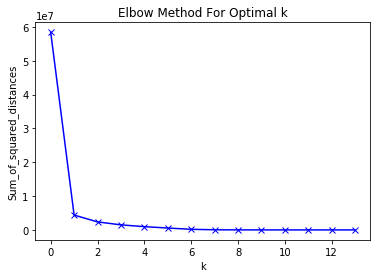

In [9]:
Sum_of_squared_distances = []
K = 15

for k in range(1, K):
    business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', k)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*let's use K = 10*

In [10]:
n_clusters = 10
business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', n_clusters)

*Lets see what states connect to to clusters*

In [11]:
groupby_lables = business_df.groupby('labels').agg(lambda x:x.value_counts().index[0])

In [12]:
state_lables = list(groupby_lables['state'])
cnt = 0
for i in state_lables: 
    print(cnt, i)
    cnt+=1

0 WI
1 NV
2 OH
3 AB
4 AZ
5 QC
6 NC
7 ON
8 PA
9 IL


In [13]:
# let's plot cluster information for nationwide visualization"""
"""
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = business_df['longitude'],
        lat = business_df['latitude'],
        text = business_df['text'],
        mode = 'markers',
        marker_color = business_df['labels'],
        ))

fig.update_layout(
        title = 'US Cluster<br>(hover for spicific informaiton)',
        geo_scope='usa',
    )
fig.show()
"""

"\nimport plotly.graph_objects as go\n\nfig = go.Figure(data=go.Scattergeo(\n        lon = business_df['longitude'],\n        lat = business_df['latitude'],\n        text = business_df['text'],\n        mode = 'markers',\n        marker_color = business_df['labels'],\n        ))\n\nfig.update_layout(\n        title = 'US Cluster<br>(hover for spicific informaiton)',\n        geo_scope='usa',\n    )\nfig.show()\n"

![img](map.png)

#### Lets investigate the review count and start of each of the clusters 

In [14]:
national_review_mean = business_df["review_count"].mean()
national_stars_mean = business_df["stars"].mean()
print("national_stars_mean = ", national_stars_mean)
print("national_review_mean = ", national_review_mean)

national_stars_mean =  3.585626839867296
national_review_mean =  33.53896235378409


In [15]:
def sortSecond(val): 
    return val[1] 

review_count = []
rating_stars = []
ratio_open_close = []
count = []
for n in range(n_clusters):
    indexes = business_df[business_df["labels"] != n].index
    temp = business_df.copy()
    temp.drop(indexes, inplace=True)
    rating_stars.append((n, temp["stars"].mean()))
    review_count.append((n, temp["review_count"].mean()))
    count.append((n, temp.count()))
    ratio_open_close.append((n, 1 - temp["is_open"].sum() / temp["is_open"].count() ))

print("Star's mean per cluster = ")
rating_stars.sort(key = sortSecond, reverse = True)
for i, value in rating_stars: 
    print(state_lables[i], value)
    
review_count.sort(key = sortSecond, reverse = True)
print("\nReview_count's mean per cluster = ")
for i, value in review_count: 
    print(state_lables[i], value) 
    
ratio_open_close.sort(key = sortSecond, reverse = True)    
print("\nRatio of closed businesses per cluster = ")
for i, value in ratio_open_close: 
    print(state_lables[i], "=", value) 
    
print("\nCount per cluster = ")
for i, value in count: 
    print("--"+state_lables[i]+"--",value)

Star's mean per cluster = 
AZ 3.7071783749471012
NV 3.696218730219886
QC 3.634898312418866
WI 3.610895696006204
PA 3.577598502406846
NC 3.539541619443395
OH 3.505374880936182
IL 3.4647850854479545
AB 3.3856143856143857
ON 3.3563926872325784

Review_count's mean per cluster = 
NV 61.79425929493354
AZ 35.327955282832555
NC 26.116861856189395
WI 25.130283055447848
PA 25.06141914779818
ON 22.77672720744442
IL 21.219057483169344
OH 21.129133215403456
QC 19.03147987884033
AB 12.08066933066933

Ratio of closed businesses per cluster = 
ON = 0.20606804105203314
IL = 0.20041429311237702
NV = 0.1858436304593114
WI = 0.18301667312911984
QC = 0.17265253137170056
AZ = 0.17241500916913532
AB = 0.16458541458541454
PA = 0.15920841504724548
NC = 0.15627754690844986
OH = 0.14648251462784057

Count per cluster = 
--WI-- business_id     5158
name            5158
address         5158
city            5158
state           5158
postal_code     5158
latitude        5158
longitude       5158
stars           515

*********
### Merging Files
* merge review, business, and user. Clean format to ensure no merge conflicts

In [16]:
%%time

review_df = JSON_to_dataFrame(root_path + "review.json")
business_df = JSON_to_dataFrame(root_path + "business.json")
user_df = JSON_to_dataFrame(root_path + "user.json")
# tip_df = JSON_to_dataFrame(root_path + "tip.json")                     /not used
# checkin_df = JSON_to_dataFrame(root_path + "checkin.json")             /not used

CPU times: user 2min 24s, sys: 2min 12s, total: 4min 37s
Wall time: 14min 58s


In [17]:
# utility function to make a dict of columns with table name added
# used for the renaming of column names
def make_columns(lst, base):
    ret = {}
    for i in lst:
        ret[i] = base + '_' + i
    return ret

In [18]:
# return dataframe with column names updated to "table + _column_name"
def process_df(a_df, table): 

    col_list = [i for i in a_df]
    new_dict = make_columns(col_list, table)
    return a_df.rename(columns=new_dict)

In [19]:
%%time

# review col = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

# ***Update review_df*** 
review_drop = ['cool','funny']
review_df = review_df.drop(review_drop, axis=1)

review_df = process_df(review_df, 'review')

CPU times: user 9.63 s, sys: 24 s, total: 33.6 s
Wall time: 43.3 s


In [20]:
%%time

# business col = 
# ['address','attributes','business_id','categories','city','hours','is_open',              
# 'latitude','longitude','name','postal_code','review_count','stars','state']                              

# ***Update business_df***
business_drop = ['address', 'postal_code']
business_df = business_df.drop(business_drop, axis=1)

business_df = process_df(business_df, 'business')

CPU times: user 1.08 s, sys: 1.51 s, total: 2.59 s
Wall time: 3.58 s


In [21]:
%%time

rb_merge = pd.merge(review_df, business_df, left_on='review_business_id', right_on='business_business_id', how='inner')

CPU times: user 22.2 s, sys: 1.23 s, total: 23.4 s
Wall time: 22.4 s


In [22]:
%%time

# user col = 
# ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list',           
# 'compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer', 
# 'cool','elite','fans','friends','funny','name','review_count','useful','user_id','yelping_since']   

# ***Update _user_df***
user_drop = ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer','cool', 'elite', 'fans','friends','funny']
user_df = user_df.drop(user_drop, axis=1)

user_df = process_df(user_df, 'user')

CPU times: user 5.21 s, sys: 11.4 s, total: 16.6 s
Wall time: 21.8 s


In [57]:
%%time

rbu_merge = pd.merge(rb_merge, user_df, left_on='review_user_id', right_on='user_user_id', how='inner')

CPU times: user 27 s, sys: 10.1 s, total: 37.1 s
Wall time: 39.8 s


In [59]:
%%time

rbu_drop = ['review_business_id','review_user_id']
rbu_merge = rbu_merge.drop(rbu_drop, axis=1)


CPU times: user 28.7 s, sys: 15.1 s, total: 43.8 s
Wall time: 45.1 s


## Filter Data to prepare for converstion back to json
* (Drop all states that are not in NV)

In [60]:
rbu_merge.shape

(6685900, 22)

In [61]:
rbu_merge, km = find_df_groups_plus_kmeans(rbu_merge, 'business_latitude', 'business_longitude', n_clusters)

In [69]:
filtered_merge = rbu_merge[rbu_merge['labels'] == 0].copy()

*********
### Writing Merged DataFrame Back To Json

In [71]:
def df_to_json(df, path):
    new_dict = {}
    num_col = len([i for i in df])

    with open(r'{}'.format(path), 'w') as writer: 

        for row in df.itertuples():
            
            for idx, col in enumerate(df): 
                if type(row[idx+1]) == int: 
                    new_dict[col] = int(row[idx+1])
                if type(row[idx+1]) == float: 
                    new_dict[col] = float(row[idx+1])
                else: 
                    new_dict[col] = str(row[idx+1])
                
            writer.write(json.dumps(new_dict) + '\n')
            new_dict = {}         



In [72]:
%%time

df_to_json(filtered_merge, filtered_merge_path)

CPU times: user 2min 37s, sys: 16.4 s, total: 2min 53s
Wall time: 2min 59s


****
### Open "filtered_merge" file for further processing

In [73]:
%%time

merged_df = JSON_to_dataFrame(filtered_merge_path)

CPU times: user 2min 7s, sys: 5min 40s, total: 7min 48s
Wall time: 14min 11s


### Visualize clustered NV informaiton

lets look at each individual business by looking for only the first entry of a business to find unique values

In [81]:
def make_unique(df, col1): 
    unique = []
    booliens = []

    for x in df[col1]:
        if x not in unique:
            booliens.append(True)
            unique.append(x)
        else:
            booliens.append(False)

    return booliens

In [83]:
booliens = []

arg1 = 'business_business_id'
booliens = make_unique(merged_df, arg1)

In [84]:
# take a look at the first 5 boolings in the collected list
booliens[:5]

[True, False, True, True, True]

In [85]:
unique_values = pd.Series(booliens)

In [86]:
# use as filter for unique values
unique_review_df = merged_df[unique_values]

In [89]:
# look at the number of business in the area
unique_review_df.business_business_id.count()

36336

In [109]:
# look at all the businesses with average star rating over 4
unique_review_df[(unique_review_df['business_stars'] > 4) & (unique_review_df['business_is_open'] == '1')].business_stars.count() 

10890

In [111]:
test_df = unique_review_df[(unique_review_df['business_stars'] > 4) & (unique_review_df['business_is_open'] == '1')].copy()

In [116]:
import folium
 
NV = (36.188820, -115.207720)
 
# for speed purposes


colors = ['#000000', '#cc0099', '#3186cc']

  
# create empty map zoomed in on San Francisco
m = folium.Map(location=NV, zoom_start=10)


# add a marker for every record in the filtered data, use a clustered view
for lat, lon in zip(test_df['business_latitude'], test_df['business_longitude']):    
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        fill=True,
        ).add_to(m) 

display(m)


********

## Unit Test

In [ ]:
test_in_path = root_path + 'test.json' 

test_df = JSON_to_dataFrame(test_in_path)

In [ ]:
%%time

test_out_path = root_path + 'test_out.json' 

parse_DataFrame1(test_df, test_out_path)

In [ ]:
test2_df = JSON_to_dataFrame(test_out_path)

In [ ]:
def test_DataFrame_to_Json(a_df_1, a_df_2): 
    
    df_list_1 = []
    df_list_2 = []
    catch_list = []
    
    for row in a_df_1.itertuples():
            
            for idx, col in enumerate(a_df_1):
                df_list_1.append((type(row[idx]), col))
                
    for row_2 in a_df_2.itertuples():
            
            for idx_2, col_2 in enumerate(a_df_2):
                df_list_2.append((type(row[idx_2]), col_2))
                
    for x,y in zip(df_list_1, df_list_2): 
        if x != y: 
            catch_list.append((x, y))
            
    for i in catch_list: 
        print(i)             # dataFrams have different types

In [ ]:
def JSON_to_dataFrame_2(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() [-500000:]] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

In [ ]:
df1 = JSON_to_dataFrame_2(rbu_path)

In [ ]:
# smaller scale test on business set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

In [ ]:
# test on full merged data set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

## Functions to check file given error message

In [ ]:
check_input_output(test_in_path, test_out_path, log_path)

In [ ]:
def check_input_output(a_test_in_path, a_test_out_path, a_log_path):
    line_count = 0
    char_count = 0
    save1 = ""
    save2 = []
    cnt1 = 0
    cnt2 = 0
    
    with open(a_test_in_path, 'r') as read1, open(a_test_out_path, 'r') as read2: 
        for x, y in zip(read1, read2):
            x = x.strip()
            y = y.strip()
            
            in_line = x.split()
            out_line = y.split()
            for word1, word2 in zip(in_line, out_line):
                
                save2.append(word1)
                
                if cnt1 > 5:
                    save2.pop(0)
                cnt1 = cnt1 + 1

            
                word_list = list(word2)
                
                for char in word_list: 
                    save1 = save1 + char
                    if cnt2 > 70: 
                        save1 = save1[1:]
                    
                    if char_count == 139: 
                        print(save1)
                        print(" ".join(save2))
                        
                    char_count = char_count + 1
                    cnt2 += 1
                
            line_count = line_count + 1


            

In [ ]:
with open(test_out_path, 'r') as reader: 
    for i in reader: 
        print(i)

****
## GCP Import
* login cradentaials provided to work with yelp_db database

In [ ]:
import sys
!{sys.executable} -m pip install PyMySQL

### MySql Server is nessisary to connect to GCP
* https://dev.mysql.com/downloads/mysql/

In [ ]:
import pymysql, os, sys, json
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
# read json file
file = "Group1/review.json"

json_data = open(file, encoding="utf8")
json_obj = [json.loads(x) for x in json_data.readlines()]


In [ ]:
num = len(json_obj)
print(num)

In [ ]:
# validate data before inserting
# TODO: check if string is the right type 
# TODO: check for duplicate data
# TODO: check for bad formats (date)

def validate_string(val): 
    if val != None: 
            if type(val) is int: 
                return str(val).encode('utf-8')
            else: 
                return val
            

### Processing takes to long so I used multiprocessing to speed up importing to host
* executing insert into gcp is atomic

this will take over 4 days to import one table!

In [ ]:
def insert_review(cursor, item, lock): 
          
    review_id = validate_string(item['review_id'])
    business_id = validate_string(item['business_id'])
    cool = validate_string(item['cool'])
    date = validate_string(item['date'])
    funny = validate_string(item['funny'])
    stars = validate_string(item['stars'])
    text = validate_string(item['text'])
    useful = validate_string(item['useful'])
    user_id = validate_string(item['user_id'])
    
    query = "INSERT INTO review(review_id,business_id,cool,date,funny,stars,text,useful,user_id) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)"
    args = (review_id, business_id, cool, date, funny, stars, text, useful, user_id)
    lock.acquire()
    cursor.execute(query, args)
    lock.release()
    
    clear_output()
    cnt.value = cnt.value + 1
    print(cnt.value)
    
    

In [ ]:
# connect to GCP MySql db insert data into review table
con = pymysql.connect(host = '104.198.65.208', user='root', password = 'hackme', db = 'yelp_db')

cnt = mp.Value('i', 0)
lock = mp.Lock()
pool = mp.Pool()


try: 
    with con.cursor() as cursor:
        
        # parse json data to SQL
        # use map to update each row in GCP
        result = pool.map([ insert_review(cursor, item, lock) for item in json_obj ])
            
finally:
    con.commit()
    con.close()
    